# BloodMNIST Classification Pipeline

## 1. Imports

In [16]:
import torch
import torch.nn as nn
import medmnist

from backend.data_loading import (
    get_data_transforms,
    load_blood_mnist_datasets,
    print_dataset_info,
    create_dataloaders,
    show_image_batch
)
from backend.models.MLP import BaselineMLP
from backend.models.CNN import BaselineCNN
from backend.model_management import (
    record_experiment,
    list_result_runs,
    load_experiment
)
from backend.training import (
    train_model,
    predict_labels,
    compute_confusion_matrix
)

## 2. Configuration

Set the hyperparameters and configuration options for the pipeline.

In [17]:
# configuration parameters
BATCH_SIZE = 128 
DOWNLOAD = True   # download the dataset if not found locally

print(f"Configuration:")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Download Dataset: {DOWNLOAD}")

Configuration:
  Batch Size: 128
  Download Dataset: True


## 3. Data Preparation

### 3.1 Get Data Transformations

Define preprocessing transformations to be applied to images.

In [18]:
print("=== Step 1: Preparing data transformations ===")
data_transform = get_data_transforms()
print("Data transformations prepared")

=== Step 1: Preparing data transformations ===
Data transformations prepared


### 3.2 Load BloodMNIST Datasets

Download and load the train, validation, and test splits.

In [19]:
print("=== Step 2: Loading BloodMNIST datasets ===")
train_dataset, val_dataset, test_dataset = load_blood_mnist_datasets(
    data_transform=data_transform,
    download=DOWNLOAD
)
print("Datasets loaded successfully")

=== Step 2: Loading BloodMNIST datasets ===
Datasets loaded successfully


### 3.3 Dataset Information

Information about the dataset splits and classes.

In [20]:
print_dataset_info(train_dataset, val_dataset, test_dataset)


Dataset Information:
Number of training samples: 11959
Number of validation samples: 1712
Number of test samples: 3421
Task: multi-class
Number of channels: 3
Number of classes: 8
Class labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}


### 3.4 Create DataLoaders

In [21]:
print("=== Step 3: Creating DataLoaders ===")
train_loader, val_loader, test_loader = create_dataloaders(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    batch_size=BATCH_SIZE
)
print("DataLoaders created successfully")

=== Step 3: Creating DataLoaders ===

Created DataLoaders with batch size 128.
DataLoaders created successfully


## 4. Data Exploration

### 4.1 Visualize Training Data

Display a batch of training images.

=== Step 4: Visualizing training data ===

Labels for the first row of images:
platelet, platelet, lymphocyte, eosinophil, eosinophil, erythroblast, basophil, lymphocyte, neutrophil, lymphocyte, eosinophil, lymphocyte, platelet, platelet, immature granulocytes(myelocytes, metamyelocytes and promyelocytes), erythroblast


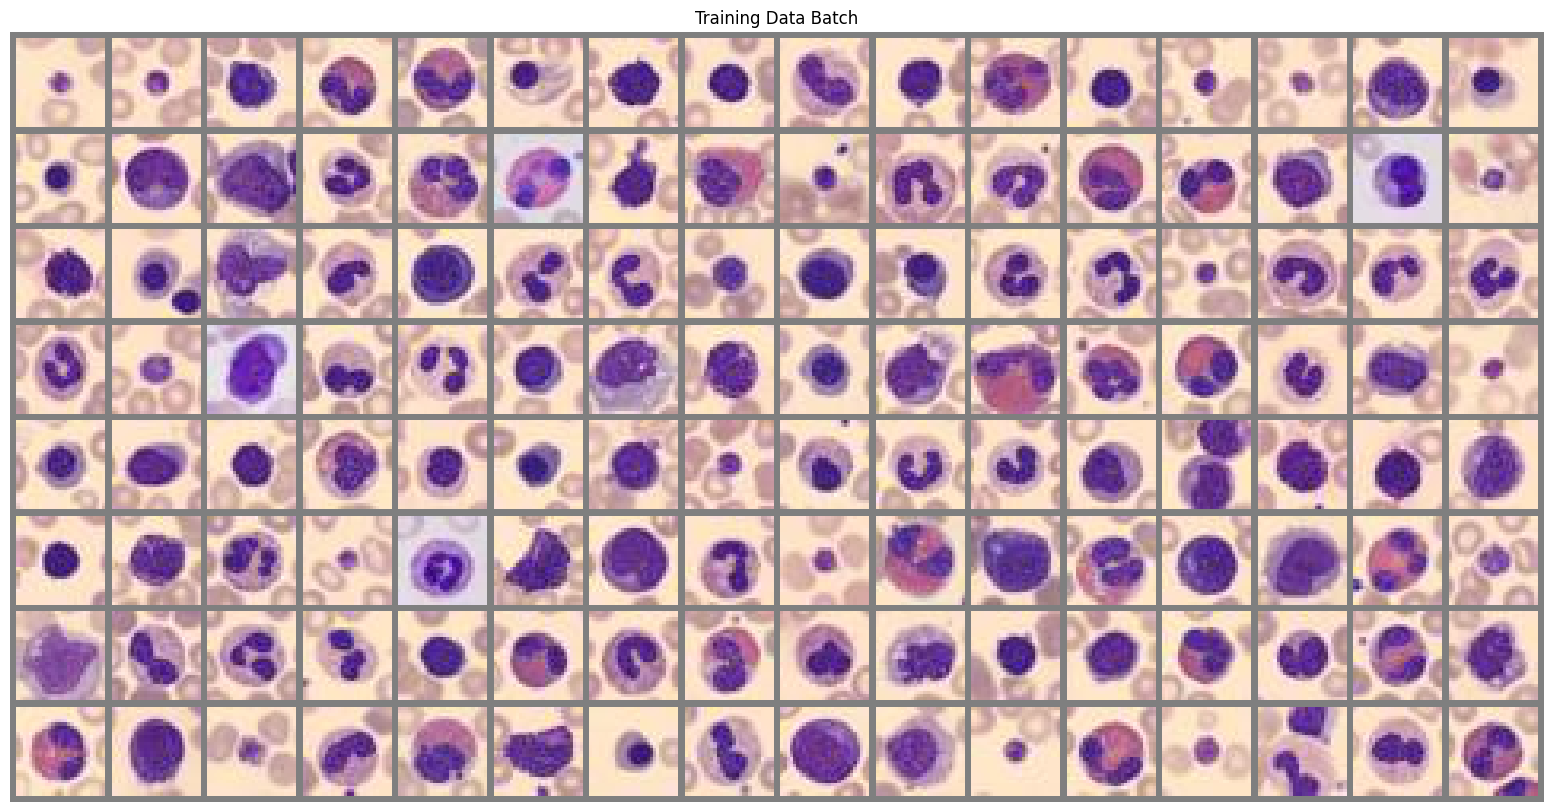

In [22]:
print("=== Step 4: Visualizing training data ===")
show_image_batch(
    data_loader=train_loader,
    dataset=train_dataset,
    title="Training Data Batch"
)

## 5. Baseline MLP Setup

Instantiate baseline classifier.

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mlp_architecture = {
    "input_shape": (3, 28, 28),
    "hidden_dims": [512, 256],
    "num_classes": len(train_dataset.info["label"]),
    "dropout": 0.2,
}

#model = build_baseline_mlp(**mlp_architecture).to(device)
model = BaselineMLP(**mlp_architecture).to(device)

current_config = model.get_config()

# Compute class weights to handle class imbalance
dataset_labels = getattr(train_dataset, "labels", None) # get labels from the dataset

labels_tensor = torch.as_tensor(dataset_labels).long().view(-1) # flatten to 1D
num_classes = mlp_architecture["num_classes"] # get number of different classes

class_counts = torch.bincount(labels_tensor, minlength=num_classes).float() # count occurrences of each class
class_weights = labels_tensor.numel() / (num_classes * class_counts.clamp(min=1.0)) # the weight is given by total_samples / (num_classes * class_count)
class_weights = class_weights.to(device=device, dtype=torch.float32) # move to device

criterion = nn.CrossEntropyLoss(weight=class_weights)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.1)


print(f"Model on {device}: {model.__class__.__name__}")
print(f"Architecture: {current_config}")
print(f"Class weights: {class_weights.cpu().numpy()}")

Model on cpu: BaselineMLP
Architecture: {'input_shape': (3, 28, 28), 'hidden_dims': [512, 256], 'num_classes': 8, 'dropout': 0.2, 'batch_norm': True}
Class weights: [1.7545482  0.68540806 1.3777649  0.73784554 1.760748   1.5054129
 0.64157724 0.90984476]


## 6. Experiment Tracking

Keep track of saved experiment runs and make reloading straightforward.

In [24]:
existing_runs = list_result_runs(model.__class__.__name__)
print(f"Existing runs for {model.__class__.__name__}: {existing_runs}")

LOAD_RESULTS_DIR = None  # e.g., "../results/BaselineMLP_20251020-153000"

if LOAD_RESULTS_DIR:
    metadata = load_experiment(
        model=model,
        results_dir=LOAD_RESULTS_DIR,
        optimizer=optimizer,
        criterion=criterion,
        map_location=device,
    )
    mlp_architecture = metadata["architecture"]
    current_config = metadata["architecture"]
    if metadata["architecture"] != model.get_config():
        print(
            "Warning: Loaded architecture metadata differs from instantiated model. "
            "Rebuild the model if needed before continuing.",
        )
    print(f"Loaded experiment from {LOAD_RESULTS_DIR}")
    print(f"Loaded architecture: {current_config}")

Existing runs for BaselineMLP: [PosixPath('/home/nuno/Documents/Blood-Cell-Types-Classifier/results/BaselineMLP_20251022-101939'), PosixPath('/home/nuno/Documents/Blood-Cell-Types-Classifier/results/BaselineMLP_20251022-104123'), PosixPath('/home/nuno/Documents/Blood-Cell-Types-Classifier/results/BaselineMLP_20251022-105002')]


## 7. MLP Training

Run the baseline MLP training loop and report epoch metrics.

In [ ]:
EPOCHS = 10
training_history, best_state = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    epochs=EPOCHS,
 )
model.load_state_dict(best_state) # load the best model state

print("Training summary:")
for epoch_idx, metrics in enumerate(training_history, start=1):
    msg = (
        f"Epoch {epoch_idx}: "
        f"train_loss={metrics.train_loss:.4f}, "
        f"train_acc={metrics.train_accuracy:.4f}"
    )
    if metrics.val_loss is not None and metrics.val_accuracy is not None:
        msg += (
            f", val_loss={metrics.val_loss:.4f}, "
            f"val_acc={metrics.val_accuracy:.4f}"
        )
    print(msg)

if any(m.val_accuracy is not None for m in training_history):
    best_epoch, best_metrics = max(
        enumerate(training_history, start=1),
        key=lambda item: item[1].val_accuracy if item[1].val_accuracy is not None else float("-inf"),
    )
    print(
        f"Best validation accuracy {best_metrics.val_accuracy:.4f} "
        f"achieved at epoch {best_epoch}.",
    )

Training summary:
Epoch 1: train_loss=0.7833, train_acc=0.7255, val_loss=0.6503, val_acc=0.7553
Epoch 2: train_loss=0.5108, train_acc=0.8205, val_loss=0.5223, val_acc=0.8411
Epoch 3: train_loss=0.4164, train_acc=0.8568, val_loss=0.5496, val_acc=0.8207
Epoch 4: train_loss=0.3539, train_acc=0.8762, val_loss=0.6419, val_acc=0.7716
Epoch 5: train_loss=0.3076, train_acc=0.8929, val_loss=0.6375, val_acc=0.7704
Epoch 6: train_loss=0.2688, train_acc=0.9054, val_loss=0.4187, val_acc=0.8581
Epoch 7: train_loss=0.2412, train_acc=0.9125, val_loss=0.6834, val_acc=0.8096
Epoch 8: train_loss=0.2080, train_acc=0.9277, val_loss=0.5423, val_acc=0.8318
Epoch 9: train_loss=0.1805, train_acc=0.9377, val_loss=0.5507, val_acc=0.8534
Epoch 10: train_loss=0.1724, train_acc=0.9386, val_loss=0.5587, val_acc=0.8423
Best validation accuracy 0.8581 achieved at epoch 6.


## 8. MLP Evaluation

Evaluate the trained MLP on the test split and persist the results.

In [ ]:
test_predictions, test_targets = predict_labels( # get the test set predictions
    model=model,
    data_loader=test_loader,
    device=device,
 )
test_accuracy = (test_predictions == test_targets).float().mean().item() # compute test accuracy (mean of correct predictions)


confusion_counts = compute_confusion_matrix( # compute confusion matrix 
    predictions=test_predictions,
    targets=test_targets,
    num_classes=current_config["num_classes"],
 )

# convert to float for metric calculations
confusion_mat = confusion_counts.to(torch.float32)

tp = confusion_mat.diagonal() # true positives per class
precision = tp / confusion_mat.sum(dim=0).clamp(min=1.0) # precision per class 
recall = tp / confusion_mat.sum(dim=1).clamp(min=1.0) # recall per class

f1_per_class = torch.zeros_like(tp) # initialize F1 per class

denominator = precision + recall # denominator for F1 calculation

non_zero = denominator > 0 # avoid division by zero
f1_per_class[non_zero] = (2 * precision[non_zero] * recall[non_zero]) / denominator[non_zero] # F1 score per class

f1_macro = f1_per_class.mean().item() # average F1 score across all classes (macro)

class_labels = [train_dataset.info["label"][str(i)] for i in range(current_config["num_classes"])]
supports = confusion_mat.sum(dim=1)
per_class_metrics = {
    label: {
        "precision": precision[idx].item(),
        "recall": recall[idx].item(),
        "f1": f1_per_class[idx].item(),
        "support": int(supports[idx].item()),
    }
    for idx, label in enumerate(class_labels)
}

print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Macro F1 score: {f1_macro:.4f}")
print("Confusion matrix (rows=true, cols=pred):")
print(confusion_counts.numpy())

print("\nPer-class metrics:")
for label, stats in per_class_metrics.items():
    print(
        f"{label}: precision={stats['precision']:.2%}, ",
        f"recall={stats['recall']:.2%}, f1={stats['f1']:.2%}, ",
        f"support={stats['support']}",
    )

metrics_summary = {
    "accuracy": test_accuracy,
    "f1_macro": f1_macro,
}
extra_metadata = {
    "per_class_metrics": per_class_metrics,
    "class_labels": class_labels,
    "training_history": [
        {
            "train_loss": m.train_loss,
            "train_accuracy": m.train_accuracy,
            "val_loss": m.val_loss,
            "val_accuracy": m.val_accuracy,
        }
        for m in training_history
    ],
}

mlp_record = record_experiment(
    model=model,
    model_name=model.__class__.__name__,
    architecture=current_config,
    criterion=criterion,
    optimizer=optimizer,
    metrics=metrics_summary,
    confusion_matrix=confusion_counts,
    extra_metadata=extra_metadata,
    model_type="MLP",
    epochs=EPOCHS,
 )
print(f"\nExperiment artifacts saved to: {mlp_record['path'].resolve()}")

Test accuracy: 0.8477
Macro F1 score: 0.8291
Confusion matrix (rows=true, cols=pred):
[[163   0   2  26   7  46   0   0]
 [  7 581   0   9   2  11  13   1]
 [  3   1 283   4   2   7   9   2]
 [ 41   3  15 349  15 132  24   0]
 [  7   0  22   9 192   8   5   0]
 [  1   0   1  23   1 258   0   0]
 [  1  12   8  24   0  17 604   0]
 [  0   0   0   0   0   0   0 470]]

Per-class metrics:
basophil: precision=73.09%,  recall=66.80%, f1=69.81%,  support=244
eosinophil: precision=97.32%,  recall=93.11%, f1=95.17%,  support=624
erythroblast: precision=85.50%,  recall=91.00%, f1=88.16%,  support=311
immature granulocytes(myelocytes, metamyelocytes and promyelocytes): precision=78.60%,  recall=60.28%, f1=68.23%,  support=579
lymphocyte: precision=87.67%,  recall=79.01%, f1=83.12%,  support=243
monocyte: precision=53.86%,  recall=90.85%, f1=67.63%,  support=284
neutrophil: precision=92.21%,  recall=90.69%, f1=91.45%,  support=666
platelet: precision=99.37%,  recall=100.00%, f1=99.68%,  support=470

## 9. Baseline CNN Setup

Instantiate a convolutional baseline to compare against the MLP results.

In [ ]:
cnn_architecture = {
    "input_channels": 3,
    "num_classes": len(train_dataset.info["label"]),
    "conv_channels": [32, 64, 128],
    "linear_dims": [128],
    "dropout": 0.3,
}

#cnn_model = build_baseline_cnn(**cnn_architecture).to(device)
cnn_model = BaselineCNN(**cnn_architecture).to(device)

cnn_config = cnn_model.get_config()

cnn_criterion = nn.CrossEntropyLoss(weight=class_weights)  # weighted loss to counter imbalance
# cnn_criterion = nn.CrossEntropyLoss()  # unweighted loss

cnn_optimizer = torch.optim.AdamW(
    cnn_model.parameters(),
    lr=1e-3,
    weight_decay=1e-2,
)
# cnn_optimizer = torch.optim.Adam(cnn_model.parameters(), lr=1e-3)

print(f"Initialized {cnn_model.__class__.__name__} on {device}")
print(f"Architecture: {cnn_config}")

Initialized BaselineCNN on cpu
Architecture: {'input_channels': 3, 'num_classes': 8, 'conv_channels': [32, 64, 128], 'linear_dims': [128], 'dropout': 0.3}


## 10. CNN Training

Train the convolutional network with the same loaders used for the MLP.

In [ ]:
CNN_EPOCHS = 15
cnn_training_history, cnn_best_state = train_model(
    model=cnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=cnn_criterion,
    optimizer=cnn_optimizer,
    device=device,
    epochs=CNN_EPOCHS,
 )
cnn_model.load_state_dict(cnn_best_state)

print("CNN training summary:")
for epoch_idx, metrics in enumerate(cnn_training_history, start=1):
    msg = (
        f"Epoch {epoch_idx}: "
        f"train_loss={metrics.train_loss:.4f}, "
        f"train_acc={metrics.train_accuracy:.4f}"
    )
    if metrics.val_loss is not None and metrics.val_accuracy is not None:
        msg += (
            f", val_loss={metrics.val_loss:.4f}, "
            f"val_acc={metrics.val_accuracy:.4f}"
        )
    print(msg)

if any(m.val_accuracy is not None for m in cnn_training_history):
    best_epoch, best_metrics = max(
        enumerate(cnn_training_history, start=1),
        key=lambda item: item[1].val_accuracy if item[1].val_accuracy is not None else float("-inf"),
    )
    print(
        f"Best validation accuracy {best_metrics.val_accuracy:.4f} "
        f"achieved at epoch {best_epoch}.",
    )

CNN training summary:
Epoch 1: train_loss=0.8868, train_acc=0.7053, val_loss=0.5703, val_acc=0.7874
Epoch 2: train_loss=0.4480, train_acc=0.8465, val_loss=0.3586, val_acc=0.8879
Epoch 3: train_loss=0.3481, train_acc=0.8800, val_loss=0.4662, val_acc=0.8002
Epoch 4: train_loss=0.2962, train_acc=0.9017, val_loss=0.3032, val_acc=0.8838
Epoch 5: train_loss=0.2554, train_acc=0.9120, val_loss=0.3525, val_acc=0.9007
Epoch 6: train_loss=0.2304, train_acc=0.9188, val_loss=0.4149, val_acc=0.8440
Epoch 7: train_loss=0.2080, train_acc=0.9293, val_loss=0.2608, val_acc=0.8943
Epoch 8: train_loss=0.1748, train_acc=0.9385, val_loss=0.4092, val_acc=0.8715
Epoch 9: train_loss=0.1572, train_acc=0.9462, val_loss=0.4232, val_acc=0.8528
Epoch 10: train_loss=0.1586, train_acc=0.9456, val_loss=0.6956, val_acc=0.8511
Epoch 11: train_loss=0.1434, train_acc=0.9506, val_loss=0.3173, val_acc=0.8978
Epoch 12: train_loss=0.1306, train_acc=0.9546, val_loss=0.1759, val_acc=0.9363
Epoch 13: train_loss=0.1167, train_acc=

## 11. CNN Evaluation

Evaluate the CNN on the test set and store the run artifacts.

In [29]:
cnn_test_predictions, cnn_test_targets = predict_labels(
    model=cnn_model,
    data_loader=test_loader,
    device=device,
 )
cnn_test_accuracy = (cnn_test_predictions == cnn_test_targets).float().mean().item()
cnn_confusion_counts = compute_confusion_matrix(
    predictions=cnn_test_predictions,
    targets=cnn_test_targets,
    num_classes=cnn_config["num_classes"],
 )
cnn_confusion_mat = cnn_confusion_counts.to(torch.float32)

cnn_tp = cnn_confusion_mat.diagonal()
cnn_precision = cnn_tp / cnn_confusion_mat.sum(dim=0).clamp(min=1.0)
cnn_recall = cnn_tp / cnn_confusion_mat.sum(dim=1).clamp(min=1.0)
cnn_f1_per_class = torch.zeros_like(cnn_tp)
cnn_denominator = cnn_precision + cnn_recall
cnn_non_zero = cnn_denominator > 0
cnn_f1_per_class[cnn_non_zero] = (
    2 * cnn_precision[cnn_non_zero] * cnn_recall[cnn_non_zero]
) / cnn_denominator[cnn_non_zero]
cnn_f1_macro = cnn_f1_per_class.mean().item()

cnn_class_labels = [
    train_dataset.info["label"][str(i)] for i in range(cnn_config["num_classes"])
]
cnn_supports = cnn_confusion_mat.sum(dim=1)
cnn_per_class_metrics = {
    label: {
        "precision": cnn_precision[idx].item(),
        "recall": cnn_recall[idx].item(),
        "f1": cnn_f1_per_class[idx].item(),
        "support": int(cnn_supports[idx].item()),
    }
    for idx, label in enumerate(cnn_class_labels)
}

print(f"CNN test accuracy: {cnn_test_accuracy:.4f}")
print(f"CNN macro F1 score: {cnn_f1_macro:.4f}")
print("CNN confusion matrix (rows=true, cols=pred):")
print(cnn_confusion_counts.numpy())

print("\nCNN per-class metrics:")
for label, stats in cnn_per_class_metrics.items():
    print(
        f"{label}: precision={stats['precision']:.2%}, ",
        f"recall={stats['recall']:.2%}, f1={stats['f1']:.2%}, ",
        f"support={stats['support']}",
    )

cnn_metrics_summary = {
    "accuracy": cnn_test_accuracy,
    "f1_macro": cnn_f1_macro,
}
cnn_extra_metadata = {
    "per_class_metrics": cnn_per_class_metrics,
    "class_labels": cnn_class_labels,
    "training_history": [
        {
            "train_loss": m.train_loss,
            "train_accuracy": m.train_accuracy,
            "val_loss": m.val_loss,
            "val_accuracy": m.val_accuracy,
        }
        for m in cnn_training_history
    ],
}

cnn_record = record_experiment(
    model=cnn_model,
    model_name=cnn_model.__class__.__name__,
    architecture=cnn_config,
    criterion=cnn_criterion,
    optimizer=cnn_optimizer,
    metrics=cnn_metrics_summary,
    confusion_matrix=cnn_confusion_counts,
    extra_metadata=cnn_extra_metadata,
    model_type="CNN",
    epochs=CNN_EPOCHS,
 )
print(f"\nCNN experiment artifacts saved to: {cnn_record['path'].resolve()}")

CNN test accuracy: 0.9380
CNN macro F1 score: 0.9330
CNN confusion matrix (rows=true, cols=pred):
[[219   1   0   8   1  11   4   0]
 [  1 615   0   2   0   2   4   0]
 [  1   0 288   7   1   3   6   5]
 [ 16   9   3 475   1  35  40   0]
 [  4   0   2  13 221   2   1   0]
 [  0   0   1  17   2 263   1   0]
 [  0   3   0   5   0   0 658   0]
 [  0   0   0   0   0   0   0 470]]

CNN per-class metrics:
basophil: precision=90.87%,  recall=89.75%, f1=90.31%,  support=244
eosinophil: precision=97.93%,  recall=98.56%, f1=98.24%,  support=624
erythroblast: precision=97.96%,  recall=92.60%, f1=95.21%,  support=311
immature granulocytes(myelocytes, metamyelocytes and promyelocytes): precision=90.13%,  recall=82.04%, f1=85.90%,  support=579
lymphocyte: precision=97.79%,  recall=90.95%, f1=94.24%,  support=243
monocyte: precision=83.23%,  recall=92.61%, f1=87.67%,  support=284
neutrophil: precision=92.16%,  recall=98.80%, f1=95.36%,  support=666
platelet: precision=98.95%,  recall=100.00%, f1=99.4

## Pipeline Summary

Pipeline execution completed! Review the results above and proceed with model training and evaluation.

In [30]:
print("\n=== Pipeline completed ===")
print("\nSummary:")
print("Data loading and preprocessing - DONE")
print("Data visualization - DONE")
print("Baseline MLP training - DONE")
print("Baseline MLP evaluation - DONE")
print("Baseline CNN training - DONE")
print("Baseline CNN evaluation - DONE")


=== Pipeline completed ===

Summary:
Data loading and preprocessing - DONE
Data visualization - DONE
Baseline MLP training - DONE
Baseline MLP evaluation - DONE
Baseline CNN training - DONE
Baseline CNN evaluation - DONE
